# Imports

In [112]:
%run 'psd_mc_functions.ipynb'

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import os

Reading XAMS data from pickles...
Read data in 5.16 seconds


In [2]:
import pandas as pd
from tqdm import tqdm

In [3]:
data_dir = '/data/xenon/ehogenbi/pulsefit/processing_pickles'

# Functions

## Reading

In [4]:
def read_pickles(dirname, base_name, max_i = None):
    if max_i is None:
        fns = os.listdir(dirname)
        fns = [os.path.join(dirname, fn) for fn in fns if base_name in fn]
        fns = np.sort(fns)
    else:
        fns = [os.path.join(dirname, base_name + '_%03d.pickle' % i) for i in range(max_i)]
    dicts = []
    for fn in fns:
        with open(fn, 'rb') as f:
            dicts.append(pickle.load(f))
    dicts =  np.concatenate(dicts)
    df = pd.DataFrame(list(dicts))
    if df.isnull().values.any():
        print('Warning: found some NaNs or Nones in the dataframe. Maybe check your computation results?')
    print('Read %d datapoints from %d files.' % (len(df), len(fns)))
    if 'stored_stat' in df.keys():
        # Brainfart when I put this in
        df['stored_stat_value'] = df['stored_stat']
        df['stored_stat'] = True
    return df



In [5]:
def read_and_combine(dirname, list_of_base):
    df_list = []
    for base_name in list_of_base:
        df_list.append(read_pickles(dirname, base_name))
    df = pd.concat(df_list)
    return df

## Plotting

In [6]:
def parslice_2d(df, x, y, key = 'chi2', **kwargs):
    '''
    Plot the minimum values of chi2 for two variables (i.e. a projection of the minimum onto the 2d slice)
    '''
    grouped = df.groupby(by = (x, y)).min()
    grouped[x] = grouped.index.get_level_values(x)
    grouped[y] = grouped.index.get_level_values(y)
    plt.scatter(grouped[x], grouped[y], c= grouped[key], **kwargs)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.colorbar(label='chi2/ndf')
    plt.show()

In [7]:
def plot_all_slices(df, vmax = None, key='chi2', **kwargs):
    '''
    Inspect the 2d slices to find the minimum.
    '''
    if vmax is None:
        vmax = np.min(df[key] * 1.5 )
    x, y = ('t3', 'fs')
    parslice_2d(df, x, y,key=key, vmax = vmax,  **kwargs)
    x, y = ('t1', 'tts')
    parslice_2d(df, x, y,key=key, vmax = vmax, **kwargs)
    x, y = ('t1', 't3')
    parslice_2d(df, x, y,key=key, vmax = vmax, **kwargs)
#     x, y = ('t3', 'tts')
#     parslice_2d(df, x, y, **kwargs)
#     x, y = ('fs', 'tts')
#     parslice_2d(df, x, y, **kwargs)
    return

In [8]:
def plot_slice_containing_point(df, x, y, row, **kwargs):
    df_sel = deepcopy(df)
    for key in row.keys():
        if (key == x) or (key == y) or (key=='chi2'):
            continue
        df_sel = df_sel[df_sel[key] == row[key]]
    plt.scatter(df_sel[x], df_sel[y], c= df_sel['chi2'], **kwargs)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.colorbar(label='chi2/ndf')
    plt.show()

In [9]:
def scan_settings_and_get_min(x, df):
    '''
    x is a list of settings dicts
    '''
    result = []
    for settings in tqdm(x):
        chi2 = recompute_chi2(df, **settings)
        minval = df.iloc[np.argmin(chi2)]
        minval = deepcopy(minval) # to shut up pandas
        minval = strip_junk(minval)
        result.append(minval)
    return pd.DataFrame(result)

## Minimum stability

In [10]:
def get_some_minima(df, n_values, key='chi2'):
    '''
    Get the minimum n points of the dataframe
    '''
    selected_minima = df.sort_values(by = key)[:n_values]
    print('Selected %d values with %s ranging from %.2f to %.2f...' % (len(selected_minima), 
                                                                       key,
                                                                         selected_minima[key].min(),
                                                                        selected_minima[key].max()))
    return deepcopy(selected_minima)

In [11]:
def check_minima(df, n_values, check_times):
    '''
    Take n minimum values, recompute them, take the mean and see if the minimum is still the minimum.
    '''
    electa = get_some_minima(df, n_values)
    electa['ranking_before'] = range(len(electa))
    chi2_new = []
    for index, settings in electa.iterrows():
        print('Working on setting %d' % index)
        settings = deepcopy(dict(settings))
        settings = strip_junk(settings)
        gofs = [gof(**settings) for _ in range(check_times)]
        chi2_new.append(np.average(gofs))
    electa['chi2_new_%d_times' % check_times] = chi2_new
    electa = electa.sort_values(by = 'chi2_new_%d_times' % check_times)
    electa['ranking_after'] = range(len(electa))
    electa = electa.sort_values(by='chi2')
    changed = electa['ranking_before'] != electa['ranking_after']
    if sum(changed) != 0:
        print('Warning: I detected a changing order!')
    return electa


In [12]:
def print_minima(mins):
    print('Giving the standard deviation for %d points...' % len(mins))
    for key in ['fs', 't3', 't1', 'tts']:
        print ("%s = %.3f +- %.3f" % (key, np.average(mins[key]), np.std(mins[key])))
    return

In [13]:
def recompute_chi2(df, **p):
    '''
    Recompute chi2 with new settings given in p.
    Parameters will be passed to `gof_manual`.
    '''
    chi2_new = []
    for i, row in df.iterrows():
        ydata, stored_stat, model, syst_err, spe_err = row[['ydata', 'stored_stat', 'model', 'syst_err', 'spe_err']]
        # print(ydata)
        chi2_new.append(gof_manual(ydata, model, syst_err, spe_err, verbose=False, stored_stat_value = stored_stat, **p))
    return np.array(chi2_new)

In [14]:
def minvalue(df, key='chi2', to_input = False):
    '''
    Take the value where minimum occurs
    '''
    minrow = df.iloc[df[key].argmin()]
    minrow = dict(minrow)
    if to_input:
        # Prepare to input into recomputing
        return minrow
    else:
        minrow = {k : v for k, v in minrow.items() if (type(v) is not np.ndarray)}
        return minrow

In [15]:
def build_fine_grid(df, n_values_min, keys, current_step_size, increase_factor = 2):
    mins = get_some_minima(df, n_values_min)
    all_points = []
    for _, minval in mins.iterrows():
        neighbours = produce_settings_dicts(keys, 
                               [minval[key] - current_step_size[i] for i, key in enumerate(keys)],
                               [minval[key] + current_step_size[i] for i, key in enumerate(keys)],
                               [1/increase_factor * current_step_size[i] for i in range(len(current_step_size))],
                                np.inf
                              )
        all_points.append(neighbours)
    all_points = np.concatenate(all_points)
    all_unique_points = [dict(t) for t in set([tuple(d.items()) for d in all_points])]
    print('Removed %d of %d settings that were nonunique, %d left...' % (len(all_points) - len(all_unique_points),
                                                                         len(all_points), len(all_unique_points)))
    good_points = [d for d in all_unique_points if ((d['t1'] > 1e-3) and (d['tts'] > 1e-3))]
    print('Also removed %d points with zero t1 or tts, %d left!' % (len(all_unique_points) - len(good_points),
                                                                   len(good_points)))
    return good_points

In [16]:
def strip_junk(dic):
    dic['stored_stat_value'] = dic['stored_stat']
    dic = {k : v for k, v in dic.items() if (type(v) is not np.ndarray) or k == 'stored_stat_value' }
    return dic

# Reading results

## ER, rect grid

### Read the data and plot projections

In [189]:
df = read_pickles('/data/xenon/ehogenbi/pulsefit/processing_pickles/', 'er')

Read 1890 datapoints from 18 files.


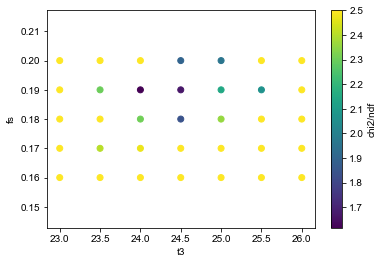

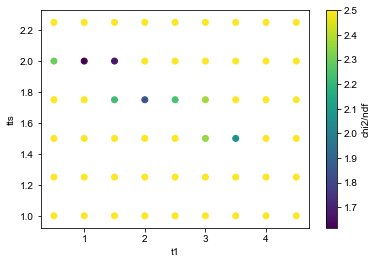

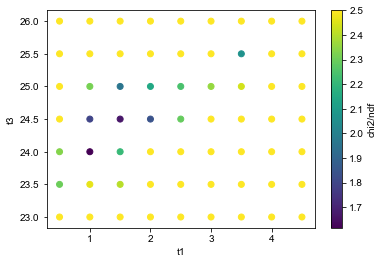

In [34]:
plot_all_slices(df, vmax=2.5)

In [197]:
minvalue(df)

{'chi2': 1.6162062569360482,
 'dset': 'er',
 'fs': 0.19,
 't1': 1.0,
 't3': 24.0,
 'tts': 2.0}

### Statistical errors, fine grid production

In [199]:
mins = get_some_minima(df, 10)
print_minima(mins)

Giving the standard deviation for 10 points...
fs = 0.190 +- 0.006
t3 = 24.600 +- 0.436
t1 = 1.650 +- 0.709
tts = 1.875 +- 0.168


In [201]:
fine = build_fine_grid(df, 20, ['fs', 't3', 't1', 'tts'], [0.01, 0.5, 0.5, 0.25])

Selected 20 values with chi2 ranging from 1.62 to 2.40...
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Removed 6846 of 12500 settings that were nonunique, 5654 left...
Also removed 175 points with zero t1 or tts, 5479 left!


In [203]:
df_fine = pd.DataFrame(fine)
mins = get_some_minima(df, 20)

Selected 20 values with chi2 ranging from 1.62 to 2.40...


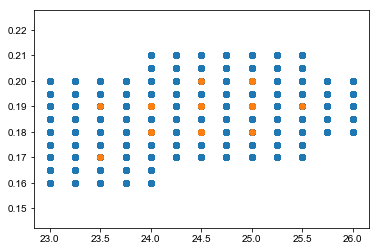

In [206]:
plt.scatter(df_fine['t3'], df_fine['fs'])
plt.scatter(mins['t3'], mins['fs'])
plt.show()

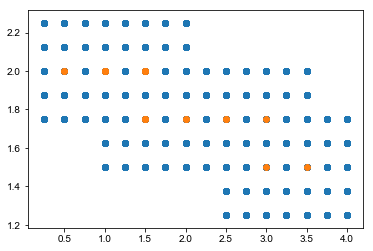

In [207]:
plt.scatter(df_fine['t1'], df_fine['tts'])
plt.scatter(mins['t1'], mins['tts'])
plt.show()

In [209]:
pickle.dump(fine, open('/data/xenon/ehogenbi/pulsefit/pickles/er_finegrid.pickle', 'wb'))

### Systematic uncertainties

In [212]:
syst_settings = produce_settings_dicts(['t_min', 't_max', 'error_offset'], [-16, 100, 0], [-4, 150, 2e-4], [4, 10, 1e-4], 
                                   block_size = np.inf)

Loaded 72 settings.


In [211]:
mins = scan_settings_and_get_min(syst_settings, df)

100%|██████████| 72/72 [02:12<00:00,  1.77s/it]


In [218]:
print_minima(mins)

Giving the standard deviation for 72 points...
fs = 0.191 +- 0.003
t3 = 24.333 +- 0.236
t1 = 1.250 +- 0.250
tts = 2.000 +- 0.000


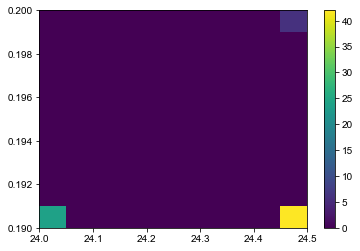

In [219]:
plt.hist2d(mins['t3'], mins['fs'])
plt.colorbar()
plt.show()

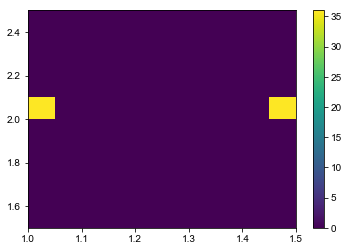

In [220]:
plt.hist2d(mins['t1'], mins['tts'])
plt.colorbar()
plt.show()

### Plot the minimum

{'n_photons': 2000000, 's1_max': 100, 's1_model': 'two_exp', 's1_sample': 'data', 't_min': -10.0, 'stored_stat_value': array([  5.93361739e-09,   1.36621542e-06,   1.84832178e-06,
         1.10661969e-06,   5.13257932e-07,   4.39087680e-07,
         6.61598350e-07,   5.50343036e-07,   1.23251041e-06,
         2.57395524e-06,   3.02959191e-06,   2.58051887e-06,
         2.07140712e-06,   1.66660381e-06,   1.85760579e-06,
         1.64821322e-06,   1.26336984e-06,   1.17561426e-06,
         2.06648570e-06,   2.66488297e-06,   1.92212134e-06,
         1.80919786e-06,   1.90672615e-06,   1.89839585e-06,
         2.92483423e-06,   2.42568217e-06,   1.57724396e-06,
         1.48367767e-06,   1.59929196e-06,   2.37645204e-06,
         2.47428619e-06,   2.04493392e-06,   1.64181840e-06,
         1.70686508e-06,   2.04238054e-06,   1.58708408e-06,
         1.92048944e-06,   3.84457801e-06,   7.27536029e-06,
         8.13475302e-06,   9.27416387e-06,   8.48428859e-06,
         8.80799923e-06,   

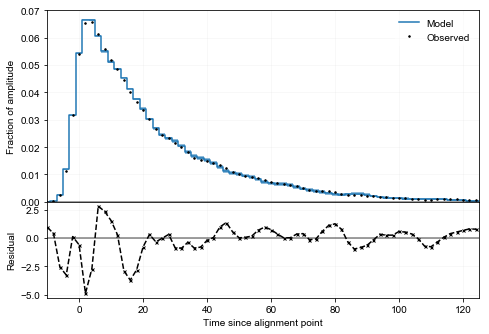

chi2 = 1.708458


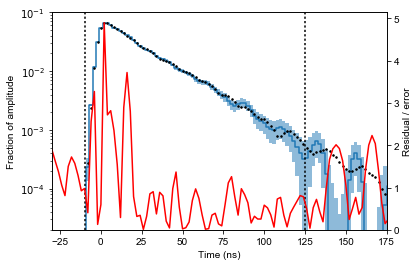

In [221]:
p = minvalue(df, key='chi2', to_input=True)
plot_model(**p)

## NR, rect grid

### Read the data and plot projections

In [19]:
df = read_pickles('/data/xenon/ehogenbi/pulsefit/processing_pickles/', 'nr')

Read 1050 datapoints from 10 files.


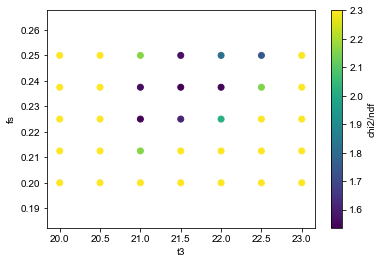

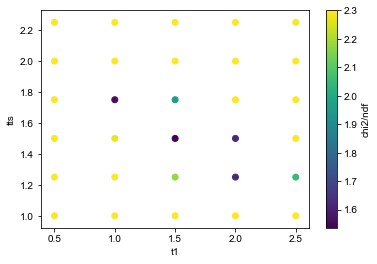

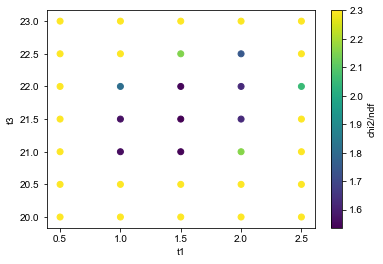

In [20]:
plot_all_slices(df, vmax=2.3)

In [21]:
minvalue(df)

{'chi2': 1.5359936092275124,
 'dset': 'nr',
 'fs': 0.23749999999999999,
 't1': 1.5,
 't3': 21.5,
 'tts': 1.5}

### Statistical errors, fine grid production

In [250]:
mins = get_some_minima(df, 20)
print_minima(mins)

Selected 20 values with chi2 ranging from 1.54 to 2.16...
Giving the standard deviation for 20 points...
fs = 0.237 +- 0.010
t3 = 21.700 +- 0.458
t1 = 1.625 +- 0.444
tts = 1.512 +- 0.185


In [251]:
fine = build_fine_grid(df, 20, ['fs', 't3', 't1', 'tts'], [0.0125, 0.5, 0.5, 0.25])

Selected 20 values with chi2 ranging from 1.54 to 2.16...
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Removed 6699 of 12500 settings that were nonunique, 5801 left...
Also removed 0 points with zero t1 or tts, 5801 left!


In [252]:
df_fine = pd.DataFrame(fine)

In [253]:
np.diff(np.unique(df['fs']))

array([ 0.0125,  0.0125,  0.0125,  0.0125])

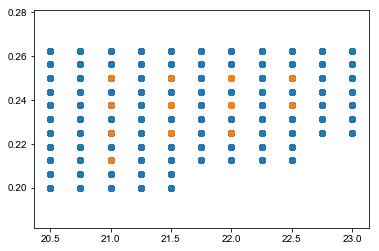

In [254]:
plt.scatter(df_fine['t3'], df_fine['fs'])
plt.scatter(mins['t3'], mins['fs'])
plt.show()

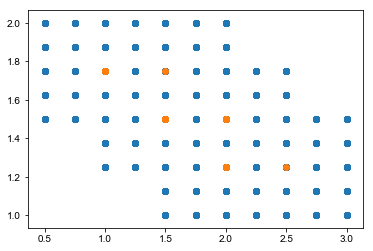

In [255]:
plt.scatter(df_fine['t1'], df_fine['tts'])
plt.scatter(mins['t1'], mins['tts'])
plt.show()

In [256]:
pickle.dump(fine, open('/data/xenon/ehogenbi/pulsefit/pickles/nr_finegrid.pickle', 'wb'))

### Systematic uncertainties

In [257]:
syst_settings = produce_settings_dicts(['t_min', 't_max', 'error_offset'], [-16, 100, 0], [-4, 150, 2e-4], [4, 10, 1e-4], 
                                   block_size = np.inf)

Loaded 72 settings.


In [258]:
mins = scan_settings_and_get_min(syst_settings, df)

100%|██████████| 72/72 [01:22<00:00,  1.09s/it]


In [259]:
print_minima(mins)

Giving the standard deviation for 72 points...
fs = 0.235 +- 0.010
t3 = 21.549 +- 0.207
t1 = 1.583 +- 0.400
tts = 1.458 +- 0.200


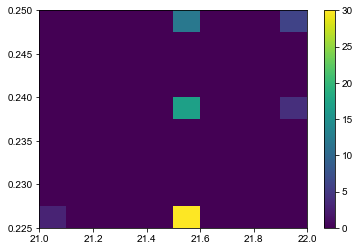

In [260]:
plt.hist2d(mins['t3'], mins['fs'])
plt.colorbar()
plt.show()

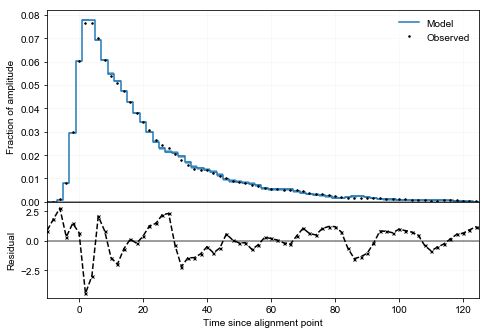

chi2 = 1.505357


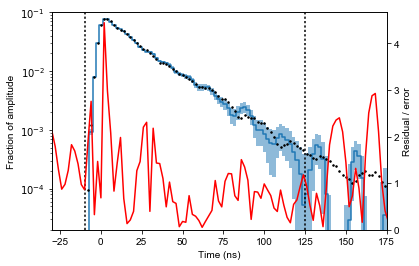

In [22]:
p = minvalue(df, key='chi2', to_input=True)
plot_model(verbose = False, **p)

In [25]:
minvalue(df)

{'chi2': 1.5359936092275124,
 'dset': 'nr',
 'fs': 0.23749999999999999,
 't1': 1.5,
 't3': 21.5,
 'tts': 1.5}

## ER energy scan

In [49]:
e_bin_i = 4

In [50]:
e_bins = [0, 5, 10, 20, 30, 50, 70]
e_min = e_bins[e_bin_i]
e_max = e_bins[e_bin_i + 1]
e = 0.5 * (e_min + e_max)
de = 0.5 * (e_max - e_min)

In [51]:
print("Range: %d to %d keVee" % (e_min, e_max))
df = read_pickles(data_dir, 'er_e_%d_%d' % (e_min, e_max))

Range: 30 to 50 keVee
Read 1890 datapoints from 3 files.


In [52]:
df.keys()

Index(['chi2', 'dset', 'e_max', 'e_min', 'fs', 'model', 'spe_err',
       'stored_stat', 'syst_err', 't1', 't3', 'tts', 'ydata',
       'stored_stat_value'],
      dtype='object')

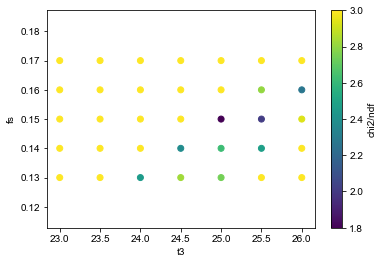

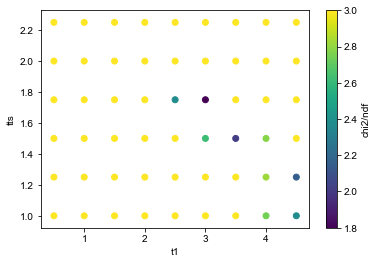

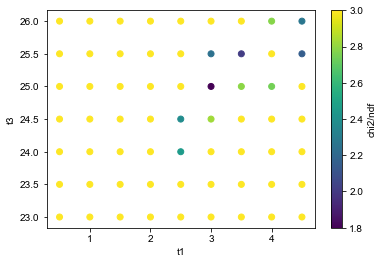

In [53]:
plot_all_slices(df, vmax = 3)

In [54]:
minvalue(df)

{'chi2': 1.7994110420334735,
 'dset': 'er',
 'e_max': 50,
 'e_min': 30,
 'fs': 0.15000000000000002,
 'stored_stat': True,
 't1': 3.0,
 't3': 25.0,
 'tts': 1.75}

In [55]:
p = minvalue(df, to_input=True)

## Data-driven spe error

In [141]:
df = read_pickles(data_dir, 'er_e_10_20_newer_spe')

Read 5103 datapoints from 25 files.


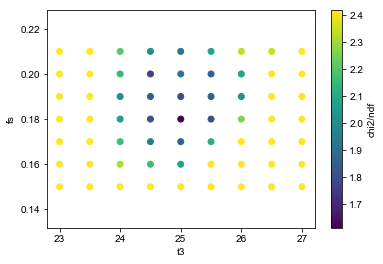

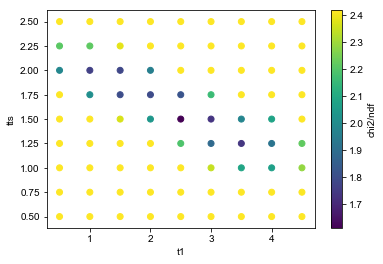

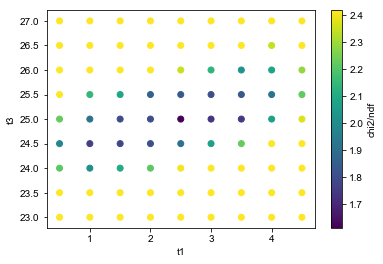

In [142]:
plot_all_slices(df)

In [143]:
minvalue(df)

{'chi2': 1.6126650051442681,
 'dset': 'er',
 'e_max': 20,
 'e_min': 10,
 'fs': 0.17999999999999999,
 'n_photons': 500000,
 'stored_stat': True,
 't1': 2.5,
 't3': 25.0,
 'tts': 1.5}

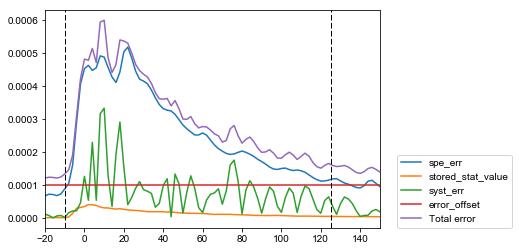

Chi2 in peak: (-10 to 30 ns): 1.93
Chi2 in tail: (30 to 125 ns): 1.48
Chi2 total: 1.61


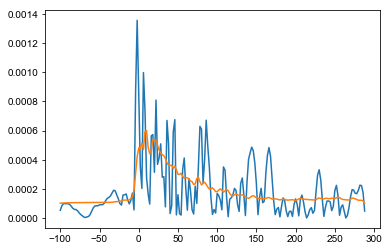

In [144]:
check_errors(**minvalue(df, to_input=True))

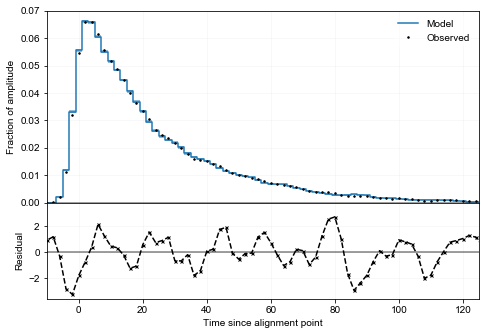

chi2 = 1.612665


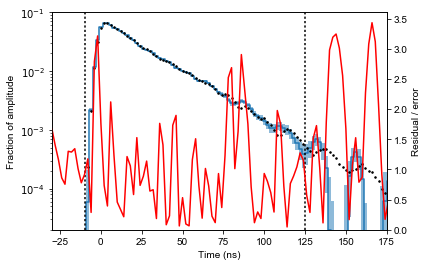

In [146]:
plot_model_manual(**minvalue(df, to_input=True))

{'s1_model': 'two_exp', 'e_min': 10, 'tr': 15, 'neglect_statistical': False, 'dset': 'er', 'aft': 0.28, 'f_r': 0.0, 't3': 25.0, 'fs': 0.17999999999999999, 'tts': 1.5, 'e_max': 20, 'n_photons': 500000, 'error_offset': 0.0001, 't_max': 125.0, 't_min': -10.0, 't1': 2.5, 'quad_adding': True, 'bootstrap_trials': 250, 'stored_stat_value': array([  3.17756171e-08,   6.15288395e-08,   7.14118360e-08,
         5.35346225e-08,   3.08491807e-08,   4.01201211e-08,
         3.91685693e-08,   3.29472124e-08,   7.58674307e-08,
         1.23186395e-07,   1.23392895e-07,   1.24414205e-07,
         1.38547003e-07,   1.51683302e-07,   1.75853407e-07,
         1.79597292e-07,   2.11854331e-07,   2.01257348e-07,
         1.86177686e-07,   2.01599629e-07,   1.77101354e-07,
         1.79018365e-07,   1.97154353e-07,   2.11998648e-07,
         2.46505936e-07,   2.40082157e-07,   2.33315873e-07,
         2.18702675e-07,   2.26285061e-07,   2.29942596e-07,
         2.37953767e-07,   2.16488872e-07,   1.82290504

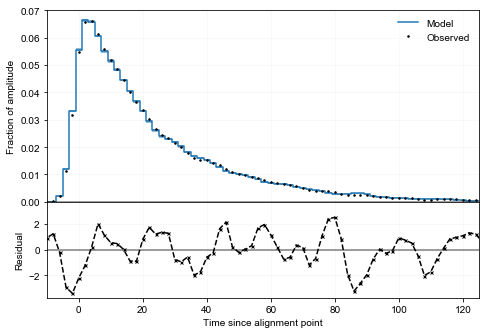

chi2 = 1.866844


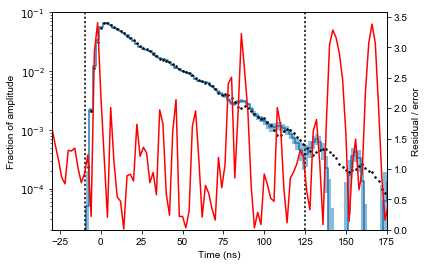

In [147]:
plot_model(**minvalue(df, to_input=False))

### Quad errors

In [124]:
p

{'chi2': 0.15445825612565142,
 'dset': 'er',
 'e_max': 20,
 'e_min': 10,
 'fs': 0.19,
 'n_photons': 500000,
 'stored_stat': True,
 't1': 1.5,
 't3': 24.5,
 'tts': 1.75}

In [125]:
model, sigma_syst, spe_err = s1_models_error(**p)

In [128]:
p['stored_stat_value'] = real_s1_wv_sigma(**p)

In [129]:
default_params['stored_stat_value'] = p['stored_stat_value']

In [130]:
# Build dicts
p = deepcopy(minvalue(df))
p1 = deepcopy(p)
p2 = deepcopy(p)

# Extract these parameters only once
# default_params['stored_stat_value'] = real_s1_wv_sigma(**p)
ydata, _ = real_s1_wv(**p)

# Now for p1...
p1['quad_adding'] = False
model, sigma_syst, spe_err = s1_models_error(**p1)
p1['ydata'], p1['model'], p1['syst_err'], p1['spe_err'] = (ydata, model, syst_err, spe_err)
p1['chi2'] = gof_manual(**p1)

# Now for p2...
p2['quad_adding'] = True
model, sigma_syst, spe_err = s1_models_error(**p2)
p2['ydata'], p2['model'], p2['syst_err'], p2['spe_err'] = (ydata, model, syst_err, spe_err)
p2['chi2'] = gof_manual(**p2)


gof=0.09465571363944048, fs=0.19, t1=1.5, t3=24.5, tts=1.75
gof=1.7652950812151533, fs=0.19, t1=1.5, t3=24.5, tts=1.75


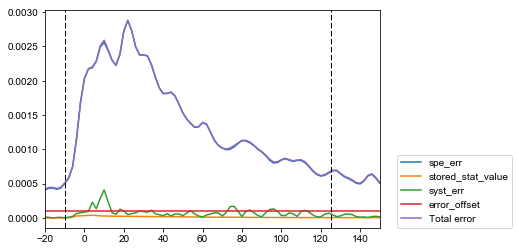

Chi2 in peak: (-10 to 30 ns): 0.13
Chi2 in tail: (30 to 125 ns): 0.08
Chi2 total: 0.09


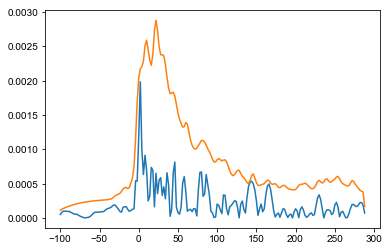

In [137]:
check_errors(**p1)

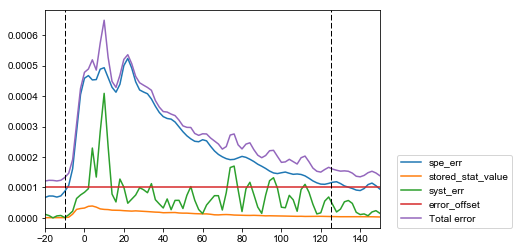

Chi2 in peak: (-10 to 30 ns): 1.90
Chi2 in tail: (30 to 125 ns): 1.71
Chi2 total: 1.77


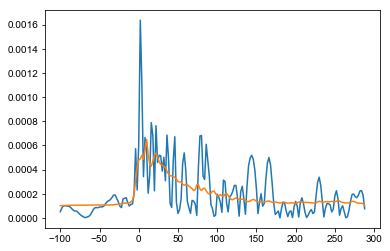

In [138]:
check_errors(**p2)

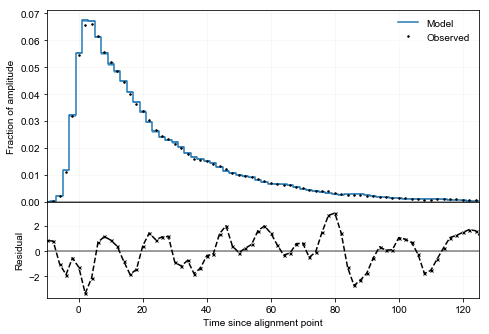

chi2 = 1.765295


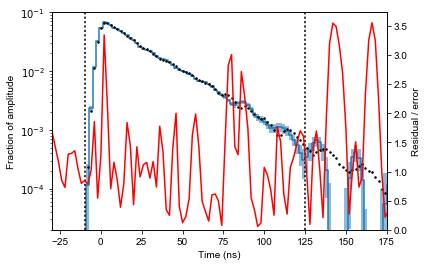

In [140]:
plot_model_manual(**p2)

In [ ]:
p1 = deepcopyy(p)

In [126]:
chi2 = gof_manual(ydata, model, syst_err, spe_err, **p)

array([  5.20008159e-05,   8.47355915e-05,   1.02297844e-04,
         1.01559138e-04,   9.87126241e-05,   9.81849245e-05,
         9.37794639e-05,   8.21374492e-05,   6.78890058e-05,
         6.17913444e-05,   6.12944478e-05,   5.41079202e-05,
         4.03611282e-05,   2.76511637e-05,   1.85283561e-05,
         9.43267479e-06,  -2.71787493e-07,  -3.95600837e-06,
        -3.84434292e-06,  -1.25557692e-05,  -3.69324599e-05,
        -6.39809951e-05,  -7.80271292e-05,  -7.77174749e-05,
        -7.68658021e-05,  -8.45702340e-05,  -8.96419877e-05,
        -8.99425294e-05,  -9.82332813e-05,  -1.14727921e-04,
        -1.29448630e-04,  -1.38047585e-04,  -1.47496811e-04,
        -1.65889237e-04,  -1.86150812e-04,  -1.85635908e-04,
        -1.57807243e-04,  -1.28605697e-04,  -1.26729894e-04,
        -1.58870012e-04,  -1.99186883e-04,  -2.19175853e-04,
        -2.14603853e-04,  -1.82281583e-04,  -1.42351299e-04,
        -1.25709451e-04,   9.84058905e-05,   2.29536223e-03,
         1.17664296e-02,

# Statistics...

In [73]:
gofs_list = []
nph_scan = [int(2e5), int(4e5), int(2e6)]
for nph in nph_scan:
    print(nph)
    popt['n_photons'] = nph
    gofs_list.append([gof(**popt) for _ in range(30)])

200000
Reading stat error from stored_stat parameter!
gof=4.847686336182956, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=5.893724830132279, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=5.6621421313708025, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=4.960056160807073, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=5.036084011427087, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=5.435783839662097, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=5.426565338782284, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=5.506808589426186, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=4.377088315327442, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!


In [88]:
nph_scan = [int(2e5), int(4e5), int(2e6), int(4e6)]

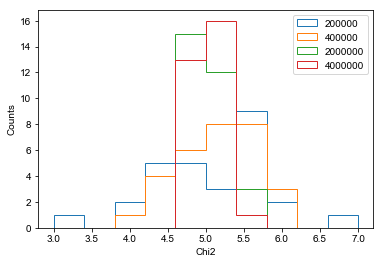

In [89]:
for gofs, l in zip(gofs_list, nph_scan):
    plt.hist(gofs, histtype = 'step', bins=10, range=(3,7), label='%d' % l)
plt.xlabel('Chi2')
plt.ylabel('Counts')
plt.legend()
plt.show()

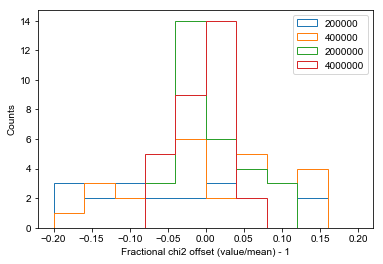

In [90]:
for gofs, l in zip(gofs_list, nph_scan):
    plt.hist(np.array(gofs) / np.mean(gofs) - 1, histtype = 'step', bins=10, range=(-.2,.2), label='%d' % l)
plt.xlabel('Fractional chi2 offset (value/mean) - 1')
plt.ylabel('Counts')
plt.legend()
plt.show()

In [91]:
np.std(gofs_list, axis=1) / np.mean(gofs_list, axis=1)

array([ 0.18106677,  0.10032424,  0.04895351,  0.0351447 ])

In [92]:
gofs_list_stat = []
nph_scan = [int(2e5), int(4e5), int(2e6)]
popt['neglect_systematic'] = False
for nph in nph_scan:
    print(nph)
    popt['n_photons'] = nph
    gofs_list_stat.append([gof(**popt) for _ in range(30)])

200000
Reading stat error from stored_stat parameter!
gof=2.994595859402191, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=1.7180867413599614, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=2.581299280602138, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=2.3044093119377864, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=3.87797057226319, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=2.3584730945375254, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=2.9466589522782445, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=2.2913916890875003, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=1.8378287717356594, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat paramet

In [94]:
np.std(gofs_list_stat, axis=1) / np.mean(gofs_list_stat, axis=1)

array([ 0.26617473,  0.19006954,  0.06307608])

#### The money plot

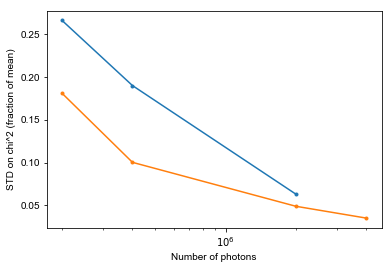

In [125]:
plt.plot(nph_scan, np.std(gofs_list_stat, axis=1) / np.mean(gofs_list_stat, axis=1), marker='.')
plt.plot(np.concatenate([nph_scan, [int(4e6)]]), np.std(gofs_list, axis=1) / np.mean(gofs_list, axis=1), marker='.')
plt.xscale('log')
plt.xlabel('Number of photons')
plt.ylabel('STD on chi^2 (fraction of mean)')

### Number of bootstrap trials

In [129]:
popt['n_photons'] = int(1e6)
popt['stored_stat'] = False

boot_scan = [20, 100, 200, 1000]
boots = []
for bt in boot_scan:
    print(bt)
    popt['bootstrap_trials'] = bt
    boots.append([gof(**popt) for _ in range(20)])


20
gof=1.934865562922848, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.294249914987514, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.897927975499547, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.20651953781785, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.3404212287590673, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.824898948772344, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.8283130743557883, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.452338891592939, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.0894702055698833, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.5820449784985073, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.9172095355070393, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.789504337155653, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.4301882420563343, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.544293321063236, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.240761883540313, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.4581112505576193, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.3309261638355525, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=

KeyboardInterrupt: 

In [135]:
for bt in [400]:
    print(bt)
    popt['bootstrap_trials'] = bt
    boots.append([gof(**popt) for _ in range(20)])

400
gof=2.169790799650517, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.0958783567618977, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.0437041529418414, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.189776783448054, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.335455337573744, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.016523940034678, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.957150616151253, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.2426380687513316, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.0268897915146216, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.7702937134946244, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.2007160689622935, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.8613155479428471, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.138296685063111, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.0494810091269486, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.7838359820359413, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.880781820935462, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.299482036700427, fs=0.19, t1=2.0, t3=25.0, tts=1.75
g

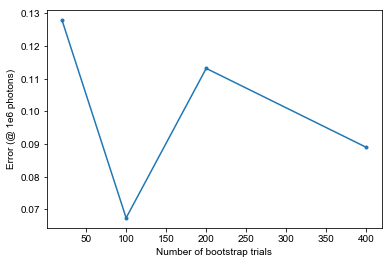

In [136]:
plt.plot([20, 100, 200, 400], np.std(boots, axis=1) / np.mean(boots, axis=1), marker='.')
plt.xlabel('Number of bootstrap trials')
plt.ylabel('Error (@ 1e6 photons)')

It looks like at 1M photons, the number of bootstrap trials is not so important as long as it is high enough (>= 100)